In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv('/content/pollen_data.csv')

In [4]:
data.head()

,Unnamed: 0,filename,pollen_carrying
0,0,P10057-125r.jpg,1
1,1,P57380-120r.jpg,1
2,2,NP63671-221r.jpg,0
3,3,NP53776-47r.jpg,0
4,4,NP13382-201r.jpg,0


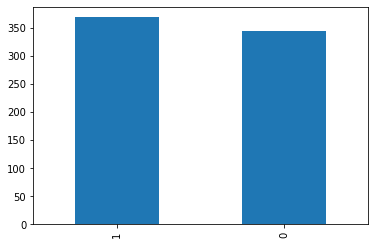

In [5]:
data['pollen_carrying'].value_counts().plot(kind='bar')

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import shutil

In [7]:
image_path='/content/images/'

In [8]:
image_list=list(data['filename'].values)

In [9]:
WIDTH=[]
HEIGHT=[]
from PIL import Image
for item in range(len(image_list)):
    current_image=image_list[item]
    image=image_path+str(current_image)
    im = Image.open(image)
    width, height = im.size
    WIDTH.append(width)
    HEIGHT.append(height)

In [10]:
Avg_width=np.round(sum(WIDTH)/len(WIDTH),0)
Avg_height=np.round(sum(HEIGHT)/len(HEIGHT),0)

In [11]:
Avg_width,Avg_height

(180.0, 300.0)

In [15]:
def image_feature(image_path,image_list):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    img_name = [];
    for i in range(len(image_list)):
        img=image_list[i]
        fname=image_path+img
        img=image.load_img(fname,target_size=(150,150))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

In [16]:
img_features,img_name=image_feature(image_path,image_list)

In [17]:
len(img_features), len(img_name)

(714, 714)

In [18]:
data.shape

(714, 3)

In [19]:
X=np.asarray(img_features)
y=data['pollen_carrying'].values

In [20]:
X.shape , y.shape

((714, 18432), (714,))

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
X_reduced = pca.transform(X_rescaled)

In [23]:
X_reduced.shape

(714, 493)

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,auc
from sklearn.naive_bayes import GaussianNB 
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import plot_confusion_matrix

In [25]:
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X_reduced,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #nb1=CatBoostClassifier(verbose=False,iterations=285,learning_rate=0.0915,depth=3,l2_leaf_reg=5.0,bootstrap_type='Bayesian',bagging_temperature=0.5,sampling_frequency='PerTreeLevel',grow_policy='Depthwise',leaf_estimation_method='Newton',model_shrink_mode='Constant',class_weights=[3,9])
    
    nb2=XGBClassifier(max_depth=7, learning_rate=0.09675, n_estimators=18,objective='binary:logistic', booster='gbtree',gamma=0.95,subsample=0.40,colsample_bytree=0.75,colsample_bylevel=0.65)

    #nb3=lgb.LGBMClassifier(objective='binary',boosting='gbdt',learning_rate =0.0975, max_depth =-1,num_leaves =225,n_estimators = 14500,bagging_fraction = 0.8,feature_fraction = 0.7,reg_alpha = 0.5,reg_lambda = 0.4)
    
    #vr=VotingClassifier([('cat',nb1),('xgb',nb2),('lgb',nb3)],voting='hard')
    eval_set = [(X_test, y_test)]
    search=nb2.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=500)
    pred_test=search.predict(X_test)
    pred_train=search.predict(X_train)
    accuracy_score_train=accuracy_score(y_train,pred_train)
    print("The accuracy_score on Train",accuracy_score_train)
    accuracy_score_test=accuracy_score(y_test,pred_test)
    print("The accuracy_score on Test",accuracy_score_test)
    print("The confusion Matrix",confusion_matrix(y_test,pred_test))
    print('*'*50)

[0]	validation_0-auc:0.689777
Will train until validation_0-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.779377
[2]	validation_0-auc:0.808363
[3]	validation_0-auc:0.827947
[4]	validation_0-auc:0.867117
[5]	validation_0-auc:0.879358
[6]	validation_0-auc:0.894438
[7]	validation_0-auc:0.910106
[8]	validation_0-auc:0.903643
[9]	validation_0-auc:0.916373
[10]	validation_0-auc:0.915198
[11]	validation_0-auc:0.919115
[12]	validation_0-auc:0.919506
[13]	validation_0-auc:0.925578
[14]	validation_0-auc:0.929299
[15]	validation_0-auc:0.925186
[16]	validation_0-auc:0.926753
[17]	validation_0-auc:0.920877
The accuracy_score on Train 0.9667250437828371
The accuracy_score on Test 0.8321678321678322
The confusion Matrix [[54 15]
 [ 9 65]]
**************************************************
[0]	validation_0-auc:0.799941
Will train until validation_0-auc hasn't improved in 500 rounds.
[1]	validation_0-auc:0.866236
[2]	validation_0-auc:0.882589
[3]	validation_0-auc:0.901097
[4]	validation_0-a

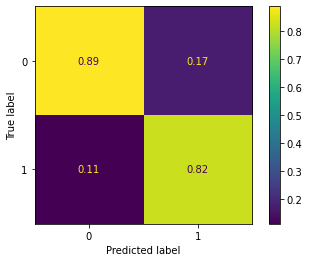

In [26]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb2, X_test, y_test,normalize='pred')  
plt.show()  

In [27]:
from sklearn.model_selection import StratifiedKFold
kf=StratifiedKFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(X_reduced,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #nb1=CatBoostClassifier(verbose=False,iterations=285,learning_rate=0.0915,depth=3,l2_leaf_reg=5.0,bootstrap_type='Bayesian',bagging_temperature=0.5,sampling_frequency='PerTreeLevel',grow_policy='Depthwise',leaf_estimation_method='Newton',model_shrink_mode='Constant',class_weights=[3,9])
    
    #nb2=XGBClassifier(max_depth=7, learning_rate=0.09675, n_estimators=18,objective='binary:logistic', booster='gbtree',gamma=0.95,subsample=0.40,colsample_bytree=0.75,colsample_bylevel=0.65)

    nb3=lgb.LGBMClassifier(objective='binary',boosting='gbdt',learning_rate =0.0975, max_depth =-1,num_leaves =31,n_estimators = 200,bagging_fraction = 0.8,feature_fraction = 0.7,reg_alpha = 0.5,reg_lambda = 0.4)
    
    #vr=VotingClassifier([('cat',nb1),('xgb',nb2),('lgb',nb3)],voting='hard')
    eval_set = [(X_test, y_test)]
    search=nb3.fit(X_train,y_train,eval_set=eval_set,eval_metric='auc',early_stopping_rounds=500)
    pred_test=search.predict(X_test)
    pred_train=search.predict(X_train)
    accuracy_score_train=accuracy_score(y_train,pred_train)
    print("The accuracy_score on Train",accuracy_score_train)
    accuracy_score_test=accuracy_score(y_test,pred_test)
    print("The accuracy_score on Test",accuracy_score_test)
    print("The confusion Matrix",confusion_matrix(y_test,pred_test))
    print('*'*50)

[1]	valid_0's auc: 0.84528	valid_0's binary_logloss: 0.648474
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's auc: 0.857423	valid_0's binary_logloss: 0.618485
[3]	valid_0's auc: 0.891206	valid_0's binary_logloss: 0.584426
[4]	valid_0's auc: 0.903447	valid_0's binary_logloss: 0.553854
[5]	valid_0's auc: 0.900313	valid_0's binary_logloss: 0.532527
[6]	valid_0's auc: 0.901782	valid_0's binary_logloss: 0.515863
[7]	valid_0's auc: 0.902957	valid_0's binary_logloss: 0.49886
[8]	valid_0's auc: 0.907854	valid_0's binary_logloss: 0.484207
[9]	valid_0's auc: 0.9104	valid_0's binary_logloss: 0.467807
[10]	valid_0's auc: 0.903937	valid_0's binary_logloss: 0.461096
[11]	valid_0's auc: 0.908441	valid_0's binary_logloss: 0.44982
[12]	valid_0's auc: 0.915394	valid_0's binary_logloss: 0.436836
[13]	valid_0's auc: 0.917744	valid_0's binary_logloss: 0.427408
[14]	valid_0's auc: 0.919311	valid_0's binary_logloss: 0.417528
[15]	valid_0's auc: 0.924207	valid_0's binary_logloss: 

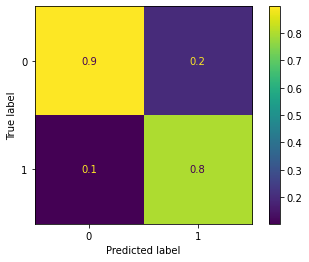

In [28]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(nb3, X_test, y_test,normalize='pred')  
plt.show()  